In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)

        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

In [ ]:
!pip install plot_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 48.7 MB/s eta 0:00:00


In [ ]:
import sys
import random
import gym
import numpy as np
from collections import defaultdict

In [ ]:
env = gym.make('Blackjack-v1')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
def get_probs(Q_s, epsilon, nA):
    """
    Get the probability of taking the best known action according to epsilon.
    Returns the policy for the Q value given
    """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In [ ]:
def best_policy(Q,nA):
    """
    returns the best actions for each Q value in the policy
    """
    return dict((k,np.argmax(v)) for k, v in Q.items())

In [ ]:
def update_Q(env, episode, Q, alpha, gamma):
    """
    Calculate the new Q values for the actions taken in the given episode.
    Returns the new Q policy
    """

    for s, a, r in episode:
        first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
        G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
        Q[s][a] = Q[s][a] + alpha*(G - Q[s][a])

    return Q

In [ ]:
def play_game(env, Q, epsilon, nA):
    """
    generates an episode from following the epsilon-greedy policy containing the state, action and reward for
    each time step in the episode.
    Returns all step information for that episode
    """
    episode = []
    state = env.reset()
    while True:
        probs = get_probs(Q[state], epsilon, nA)
        action = np.random.choice(np.arange(nA), p=probs) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [ ]:
epsilon = 1.0
eps_min = 0.01
decay = 0.9999
alpha = 0.001
gamma = 1.0

nA = env.action_space.n
Q = defaultdict(lambda: np.zeros(nA))
def mc_control(env, num_episodes):
    """
    main method. Iterates through episodes updating epsilon after each, retrieves the list of states, actions
    and rewards from the last episode and use them to calculate the updated Q values
    """


    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        epislon = max(epsilon*decay, eps_min)
        episode = play_game(env, Q, epsilon, nA)
        Q = update_Q(env, episode, Q, alpha, gamma)

    policy = best_policy(Q, nA)
    return policy, Q

In [ ]:
def mc_predict(env, num_episodes, gamma=1.0):

    """
    This is the primary method. Plays through several episodes of the environment.
    """
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        episode = play_episode(env)

        update_Q(episode, Q, returns_sum, N)

    return Q

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def play_episode(env):
    """
    Plays a single episode with a set policy in the environment given. Records the state, action
    and reward for each step and returns the all timesteps for the episode.
    """
    episode = []
    state = env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [ ]:
def update_Q(episode, Q,returns_sum, N, gamma=1.0):
    for s, a, r in episode:
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
            G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
            returns_sum[s][a] += G
            N[s][a] += 1.0
            Q[s][a] = returns_sum[s][a] / N[s][a]

Episode 1000/500000.

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 500000/500000.

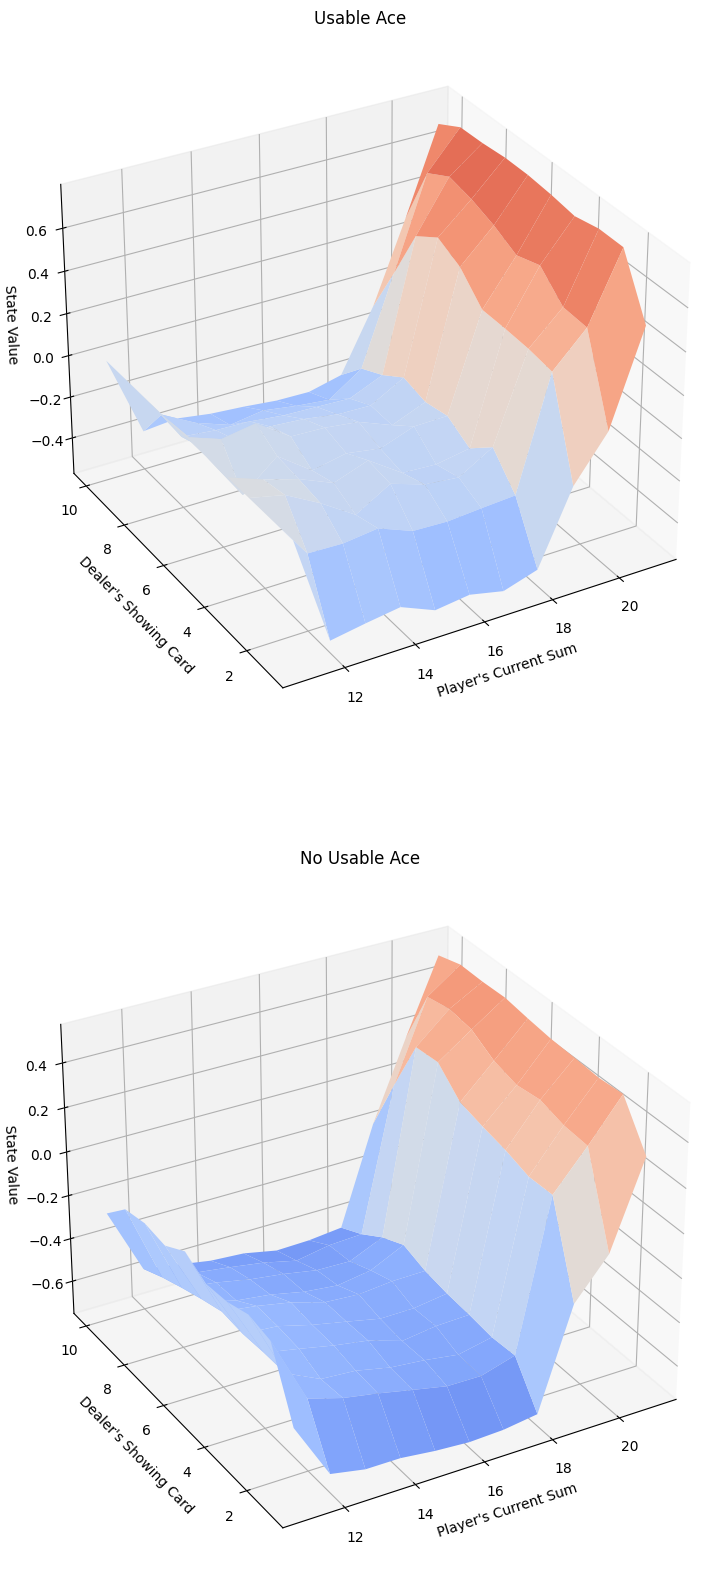

In [ ]:
Q = mc_predict(env, 500000)
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())
plot_blackjack_values(V_to_plot)

Episode 100000/100000.

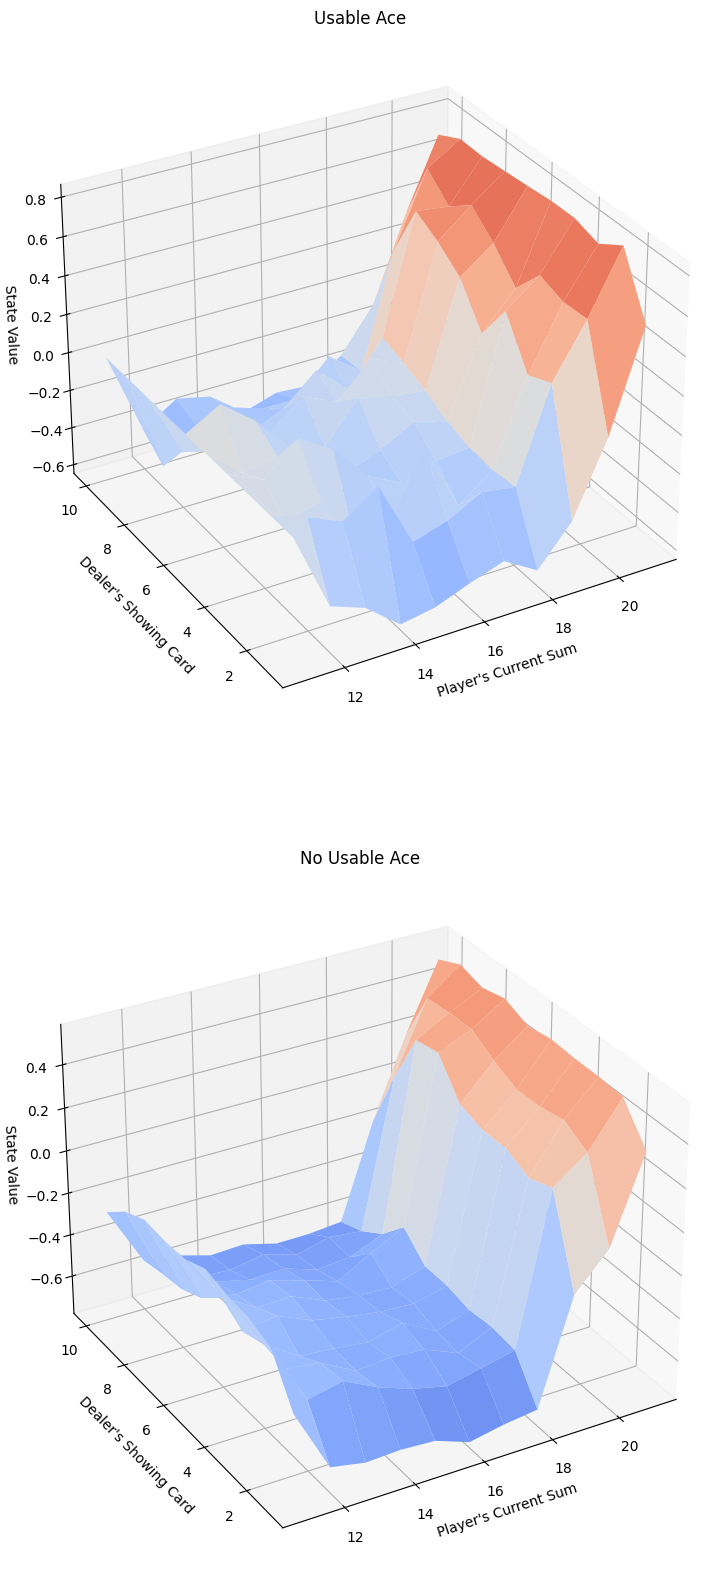

In [ ]:
Q = mc_predict(env, 100000)
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())
plot_blackjack_values(V_to_plot)